### Dropout with L2 Weight Regularization

In [17]:
import numpy as np
import keras 
from keras.datasets import mnist
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.layers import Dense,Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,Dropout
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
from keras import optimizers,regularizers

In [18]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))
        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)
        self.val_recalls.append(recall_score(y_val, y_predict, average=None))
        self.val_precisions.append(precision_score(y_val, y_predict, average=None))
        self.val_f1s.append(f1_score(y_val,y_predict, average=None))

In [19]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# print(X_train.shape)
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0],28, 28,1).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28, 28,1).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# # one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(y_train.shape)
num_classes = y_test.shape[1]
print(num_classes)

input_shape=(28,28,1)
epochs=10
batch_size = 512
history = AccuracyHistory()

(60000, 10)
10


In [20]:
def create_deep_model(opt,loss):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.20))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01)))
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
    
    return model

In [21]:
def create_optimizer(opt_name,lr,decay):
    if opt_name == "SGD":
        opt = optimizers.SGD(lr=lr, decay=decay)
    elif opt_name == "Adam":
        opt = optimizers.Adam(lr=lr, decay=decay)
    elif opt_name == "RMSprop":
        opt = optimizers.RMSprop(lr=lr, decay=decay)
    elif opt_name == "Adagrad":
        opt = optimizers.Adagrad(lr=lr, decay=decay)
        
    return opt

def create_model(filters,filt1_size,conv_stride,pool_size,pool_stride,opt,loss):
    model=Sequential()
    model.add(Conv2D(filters, kernel_size=(filt1_size, filt1_size), strides=(conv_stride, conv_stride),activation='relu',input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size), strides=(pool_stride,pool_stride), padding='valid'))
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
    
    return model

In [22]:
def fit_model(epochs,batch_size):
    model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.05,callbacks=[history])
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    y_pred = model.predict_classes(X_test)
    cnf_mat = confusion_matrix(np.argmax(y_test,axis=1), y_pred)

    return cnf_mat,score,y_pred

In [23]:
lr = 0.001
decay = 1e-6
#decay = 0.0
epochs=10
batch_size = 1024

opt = create_optimizer('Adam',lr,decay)
loss = "categorical_crossentropy"

filters,filt1_size,conv_stride,pool_size,pool_stride = 32,7,1,2,2
model = create_deep_model(opt,loss)

print(model.summary())

cnf_mat,score,y_pred = fit_model(epochs,batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         73856     
__________

In [24]:
from keras.models import load_model
model.save('Dropout_model_MNIST.h5')
fscore=f1_score(np.argmax(y_test,axis=1), y_pred,average=None)
recall=recall_score(np.argmax(y_test,axis=1), y_pred,average=None)
prec=precision_score(np.argmax(y_test,axis=1), y_pred,average=None)

In [25]:
def plot(r1,r2,data,Info):
    plt.plot(range(r1,r2),data)
    plt.xlabel('Epochs')
    plt.ylabel(Info)
    plt.show()

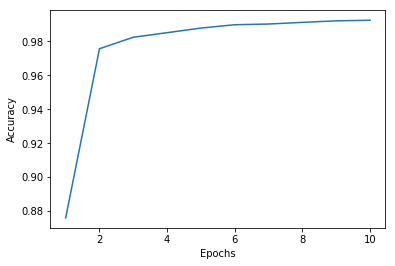

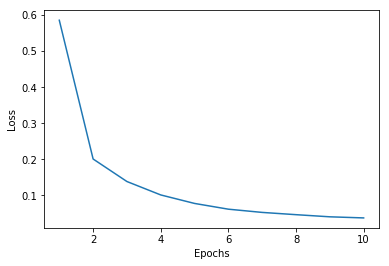

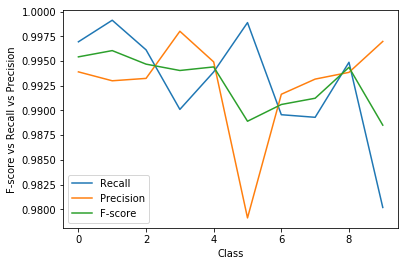

In [26]:
plot(1,epochs+1,history.acc,'Accuracy')
plot(1,epochs+1,history.loss,'Loss')
plt.plot(recall,label='Recall')
plt.plot(prec,label='Precision')
plt.xlabel('Class')
plt.ylabel('F-score vs Recall vs Precision')
plt.plot(fscore,label='F-score')
plt.legend()

In [28]:
avg_fscore=np.mean(fscore)
print(avg_fscore)
avg_precision=np.mean(prec)
print(avg_precision)
avg_recall=np.mean(recall)
print(avg_recall)

0.9928159736299671
0.9927773550186165
0.992895582504149


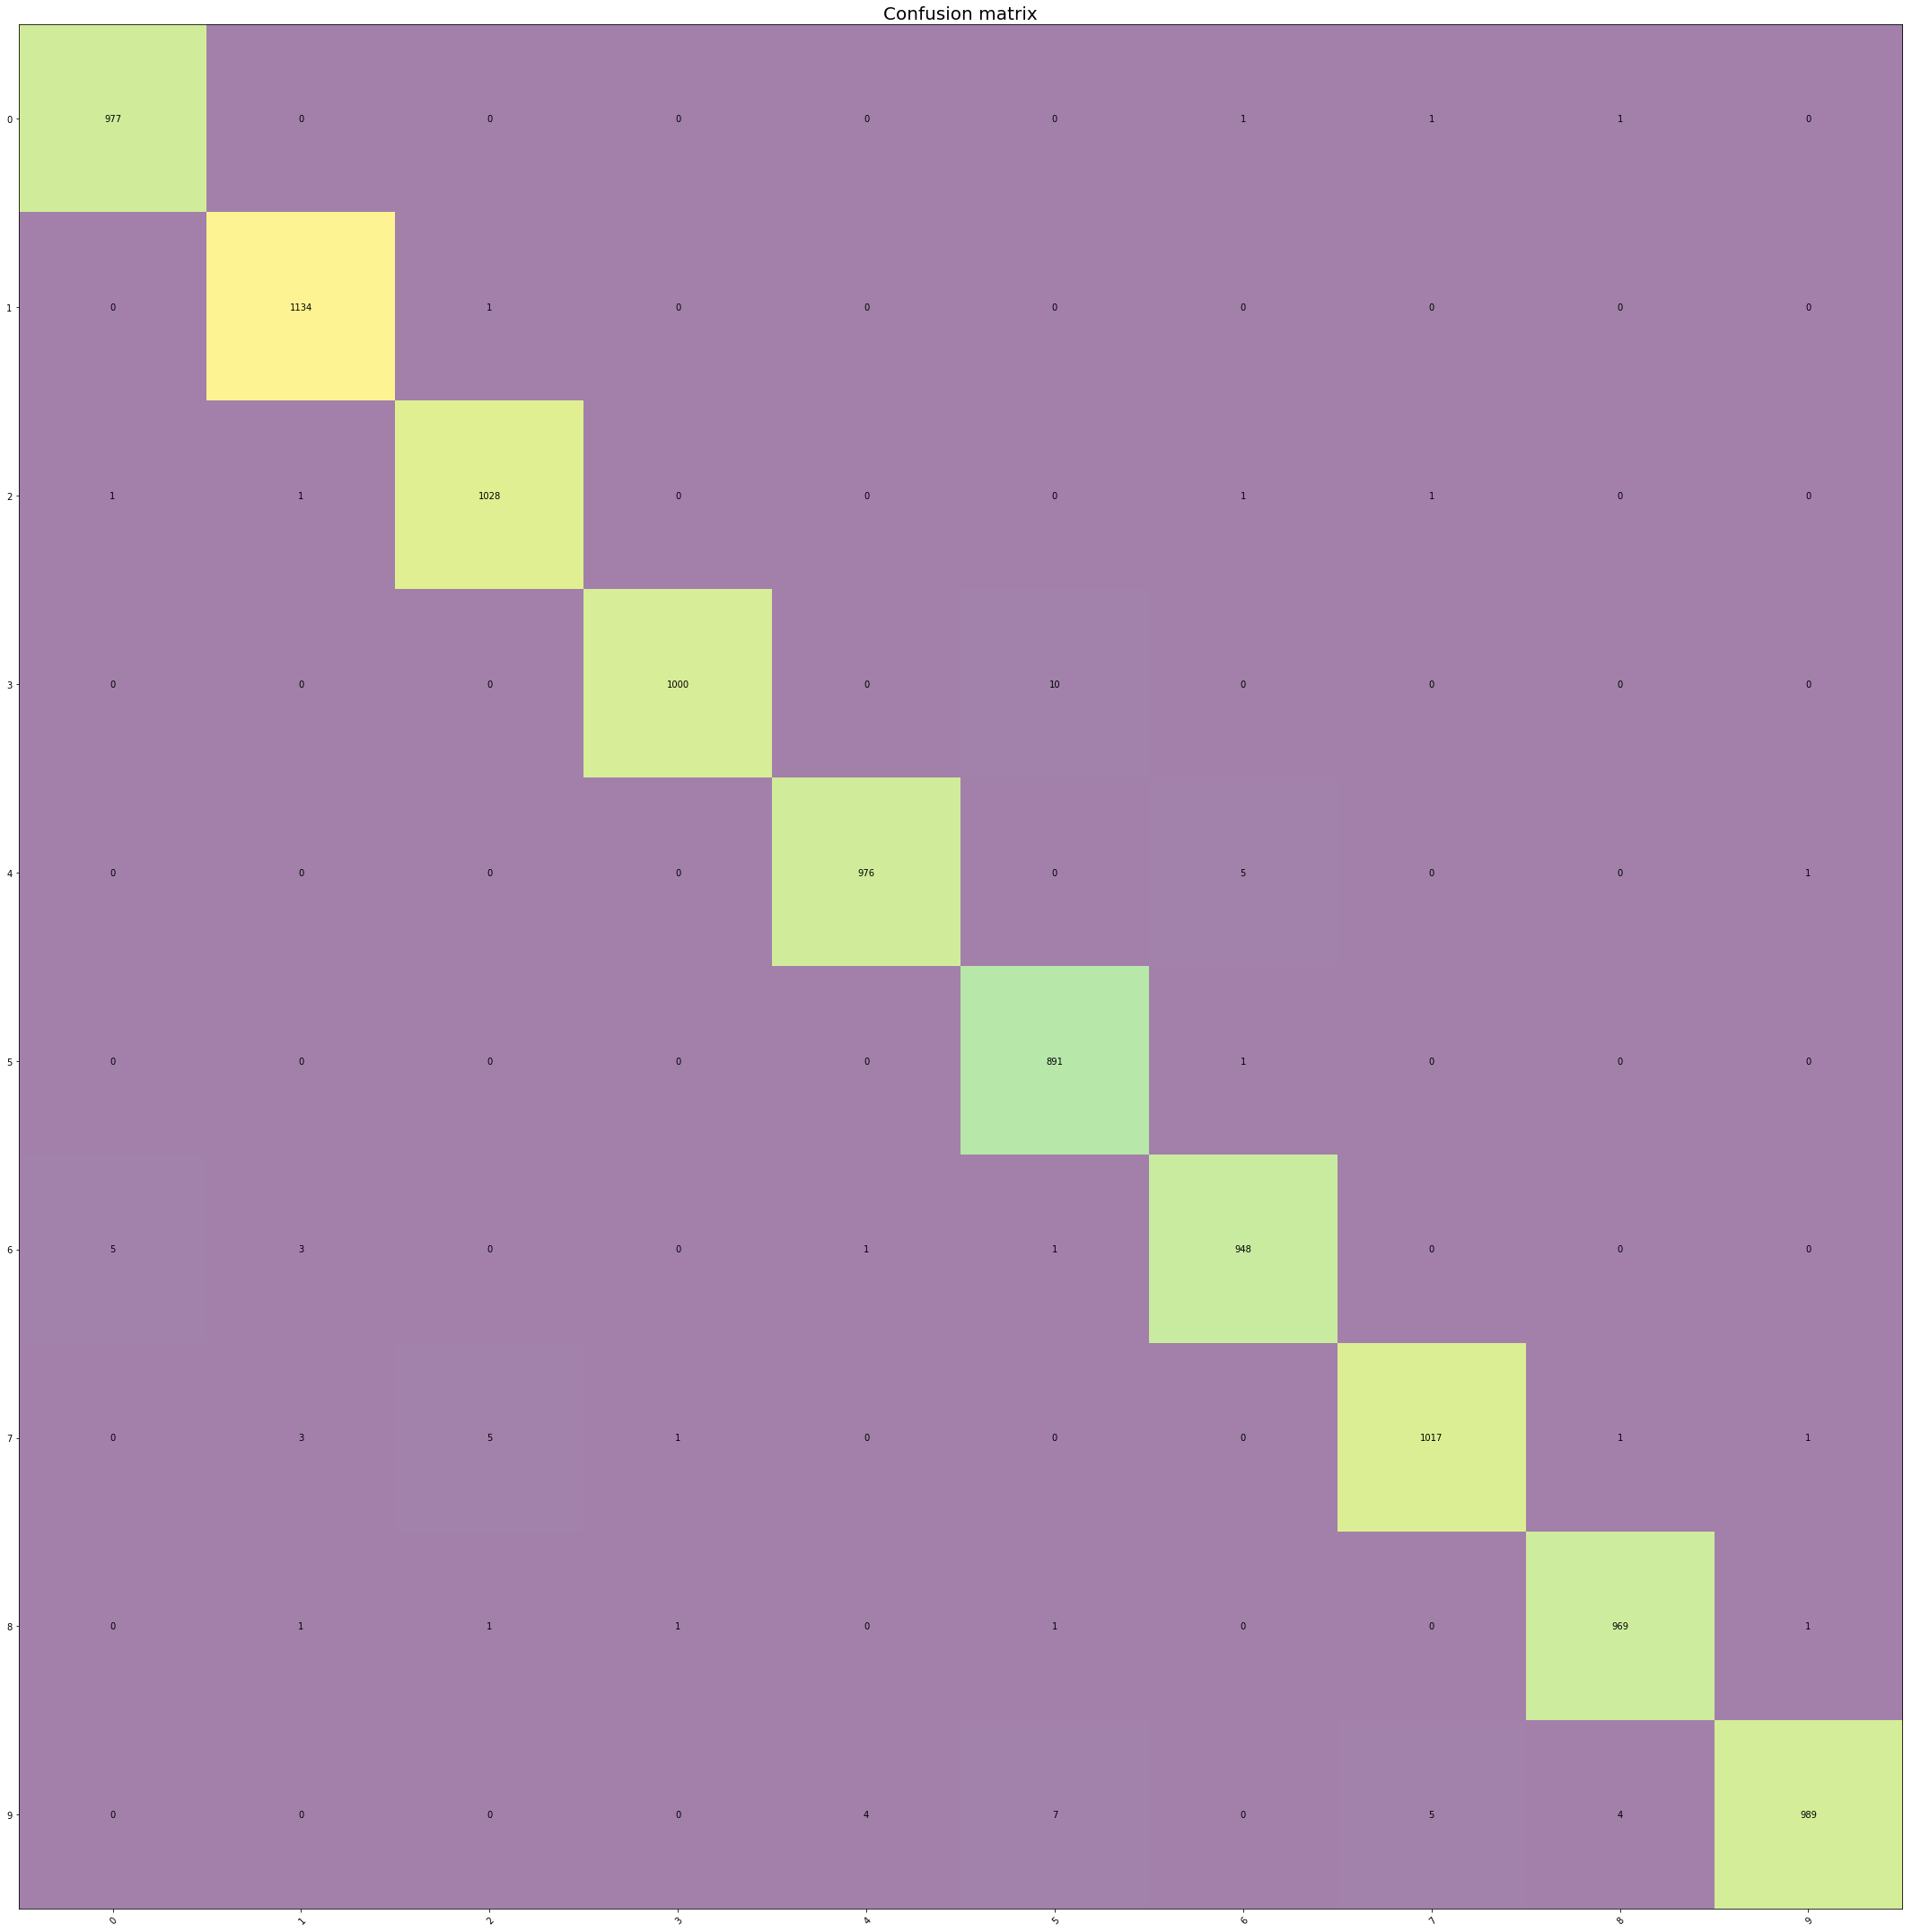

In [29]:
cnf_mat = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


conf = cnf_mat


fig, ax = plt.subplots(figsize=(30,30))
im = ax.imshow(conf,alpha=0.5)
# plt.show()

# We want to show all ticks...
ax.set_xticks(np.arange(cnf_mat.shape[0]))
ax.set_yticks(np.arange(cnf_mat.shape[1]))
# ... and label them with the respective list entries
ax.set_xticklabels(np.arange(0,96))
ax.set_yticklabels(np.arange(0,96))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(cnf_mat.shape[0]):
    for j in range(cnf_mat.shape[1]):
        text = ax.text(j, i, conf[i, j],
                       ha="center", va="center",color="black",fontsize=10)
ax.set_title("Confusion matrix",fontsize=20)
fig.tight_layout()

# fig.savefig('plot1_cnf.png')
plt.show()

In [30]:
del model